**Date: 24th Aug 2021** \
**Author: Osama Sidahmed**

On the previous notebook, some EDA was done, the data was preprocessed and some baseline modelling using Logistic regression and SVM was performed after which we made a quick comparison of the best estimators evaluation metrics. At the end of the notebook we saved our cleaned dataframes so that we use them on this notebook that we will use for doing some deeplearning modelling.

### Deeplearning modelling

#### Keras Dense Network

In this section we will attempt Dense networks to solve for our problem. First, a standard dense neural network will be fitted and evaluated and we will look at some visuals to aid us check for any signs for overfitting. This will help setup the best model on the Grid search later in terms of the model structure and the hyperparameters range.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import libraries
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier # for Keras NN CV

As we have done all the necessary pre-processing on the preceding notebook, we can just load the csv file we saved at the end of that notebook and use the data within on this notebook as mentioned earlier.

In [5]:
# Read csv file containing the database dataframes
df_train_lemma_sc = pd.read_csv('data/' + 'df_train_lemma_sc.csv')
df_test_lemma_sc = pd.read_csv('data/' + 'df_test_lemma_sc.csv')

In [6]:
df_train_lemma_sc.head(), df_test_lemma_sc.head()

(     id  target                              text_spacy_Lemmatized
 0  3296       0   the   sector have see a deluge of disruption ...
 1   258       0   nicki minaj single handedly annihilate the ma...
 2  4898       1   dmregister  rt tdavisdmr  a man be believe to...
 3  8980       0   I m scream bc the baby probably still see in ...
 4  7919       0   surprising oil tanker spill statistic publish...,
      id  target                              text_spacy_Lemmatized
 0  6211       0   when your dog  cat start pee on it  crap in t...
 1   589       1   after the attack  the soldier be surprised th...
 2  2741       0   do your research to find out if something lik...
 3  9614       0   the actual reason he wo nt have a problem be ...
 4  5108       0   hello  ph social medium  sorry for loudness  ...)

Now, we need to split X and y. Note that the data is already split into train and test set from the previous notebook, this will make it easier to compare with the baseline models.

In [111]:
# define our X_train and y_train
X_train = df_train_lemma_sc['text_spacy_Lemmatized'].fillna(' ')
y_train = df_train_lemma_sc['target']

In [112]:
# define our X_test and y_test
X_test = df_test_lemma_sc['text_spacy_Lemmatized'].fillna(' ')
y_test = df_test_lemma_sc['target']

In [113]:
# confirm the dataframes shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8512,), (2838,), (8512,), (2838,))

Now since this data is just cleaned data, we still need to create our features before modelling.

Before we do any modelling, we will prepare our train and test data for Keras networks, this include:
- Fitting and transforming our X data using the bag of words for our initial model

For now will not be splitting our train data to train/val sets but will rather use the Keras built-in `validation_split` param to split our validation data while modelling.

In [114]:
# sanity check -  our X_train data
X_train.head()

0     the   sector have see a deluge of disruption ...
1     nicki minaj single handedly annihilate the ma...
2     dmregister  rt tdavisdmr  a man be believe to...
3     I m scream bc the baby probably still see in ...
4     surprising oil tanker spill statistic publish...
Name: text_spacy_Lemmatized, dtype: object

In [115]:
# sanity check -  our y_train data
y_train.head()

0    0
1    0
2    1
3    0
4    0
Name: target, dtype: int64

In [118]:
# Fitting and transforming our X data using the bag of words for our initial model
transformer  = CountVectorizer(stop_words='english').fit(X_train)
X_train_transformed_dense = transformer.transform(X_train).todense()

In [119]:
# check the resulting densee martix
X_train_transformed_dense

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

The reason we transformed the matrix to dense is because of the large number of zero-valued elements on our matrix. As you can see below, we have more than 14,000 columns. We did some work in the previous models to reduce that but we will keep this as is for now as this is only an initial model. We have the opportunity to improve this later.

In [120]:
# the shape of the X data
X_train_transformed_dense.shape

(8512, 14061)

In [121]:
# ensuring that the data is string type
type(X_train.iloc[0])

str

In [122]:
y_train.shape

(8512,)

For the sake of modelling, we need to reshape the matrix so that it is compatible with Keras as following:

In [126]:
# reshape the target data matrix
y_train_reshaped  = y_train.values.reshape(-1,1)

In [127]:
y_train_reshaped

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [129]:
# and confirming the shape
y_train_reshaped.shape

(8512, 1)

In [130]:
# Random seed for reproducibility
seed = 1
np.random.seed(seed)

In [137]:
# Define the merics
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


# create model
model = keras.Sequential()
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dropout(0.25)) # Set 20% drop out
# model.add(layers.Dense(6, activation='relu'))
# model.add(layers.Dropout(0.25)) # Set 20% drop out

# Declare the output layer
model.add(layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.00025), 
              metrics = METRICS)

In [138]:
# Fit model
history = model.fit(X_train_transformed_dense,
                    y_train_reshaped, epochs=15, verbose=1, validation_split=0.25)

Epoch 1/15
200/200 [==============================] - 3s 15ms/step - loss: 0.6448 - tp: 126.0000 - fp: 298.0000 - tn: 4877.0000 - fn: 1083.0000 - accuracy: 0.7837 - precision: 0.2972 - recall: 0.1042 - auc: 0.5934 - val_loss: 0.5862 - val_tp: 4.0000 - val_fp: 0.0000e+00 - val_tn: 1753.0000 - val_fn: 371.0000 - val_accuracy: 0.8257 - val_precision: 1.0000 - val_recall: 0.0107 - val_auc: 0.6991
Epoch 2/15
200/200 [==============================] - 2s 8ms/step - loss: 0.5359 - tp: 65.0000 - fp: 2.0000 - tn: 5173.0000 - fn: 1144.0000 - accuracy: 0.8205 - precision: 0.9701 - recall: 0.0538 - auc: 0.7612 - val_loss: 0.4957 - val_tp: 18.0000 - val_fp: 1.0000 - val_tn: 1752.0000 - val_fn: 357.0000 - val_accuracy: 0.8318 - val_precision: 0.9474 - val_recall: 0.0480 - val_auc: 0.7463
Epoch 3/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4511 - tp: 160.0000 - fp: 2.0000 - tn: 5173.0000 - fn: 1049.0000 - accuracy: 0.8354 - precision: 0.9877 - recall: 0.1323 - auc: 0.8436 - va

We trained the model for 15 epochs, while monitoring our metrics, it is much easier, however if we can plot the history of epochs to understand the model performance.

In [139]:
# Evaluate the network
train_accuracy = history.history['accuracy'][-1]
result = model.evaluate(transformer.transform(X_test).todense()
                        ,y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}") 

# Generate predictions
predictions = model.predict(transformer.transform(X_test).todense())

Train Accuracy: 0.9585
Test Accuracy: 0.8774


Just looking at the train and test accuracy scores, it seems that there is a considerable overfitting in our network training. This can be explained by the cross in training and validation losses at the about the forth epoch, after which the validation loss rate of diminishing started to decrease compared to the training set. Looking at this plot alone, it can be said that we should have stopped our training at epoch 4. 

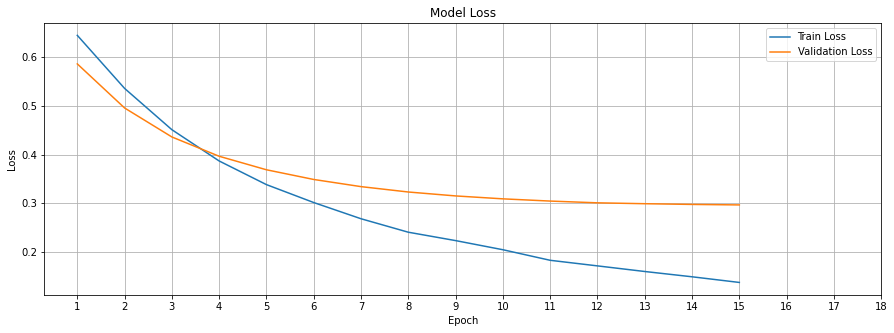

In [148]:
# Plot Train Loss and Validation Loss
plt.figure(figsize=(15, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'])
plt.grid()
plt.xticks(np.arange(len(history.history)), np.arange(1, len(history.history)+1)) # to start the plot from 1

plt.show()

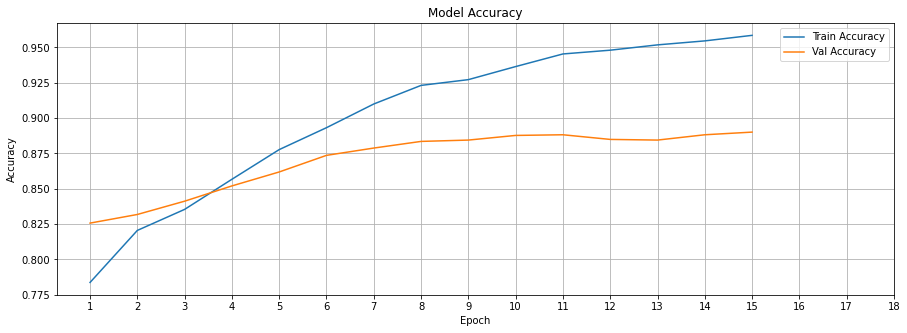

In [147]:
# Plot the train and val accuracy
plt.figure(figsize=(15, 5))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Val Accuracy'])
plt.grid()
plt.xticks(np.arange(len(history.history)), np.arange(1, len(history.history)+1)) # to start the plot from 1

plt.show()

After plotting the accuracy scores, we see that there was some relative gain in the validation accuracy for another two epochs - until epoch 6 - with no much jump in the training set accuracy score.

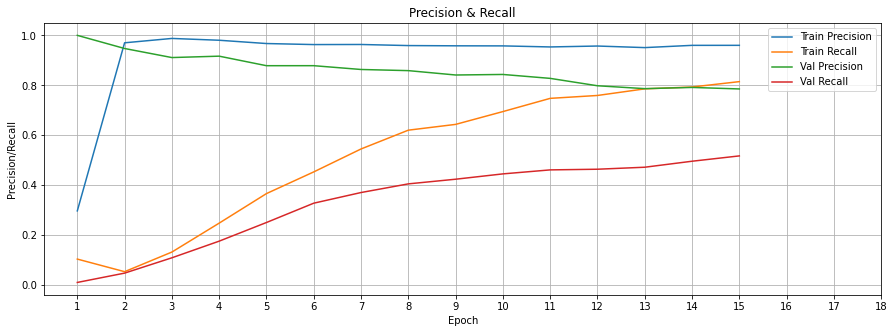

In [146]:
plt.figure(figsize=(15, 5))

plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])

plt.title('Precision & Recall')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['Train Precision', 'Train Recall', 'Val Precision', 'Val Recall'])
plt.grid()
plt.xticks(np.arange(len(history.history)), np.arange(1, len(history.history)+1)) # to start the plot from 1

plt.show()

Now plotting the precision and recall scores, has added another dimension to the decision criteria. Looking at the validation set lines and seeing them converge over time, we should ask ourselves an important question, do we care more about precision or recall?

In [143]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history["accuracy"][-1]
result = model.evaluate(transformer.transform(X_test).todense(),
                        y_test, verbose=0)

# loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")
print(f"Test Precision: {result[6]:.4f}")
print(f"Test Recall: {result[7]:.4f}")
print(f"Test AUC: {result[8]:.4f}")
print(f"Test TP: {result[1]:.0f}")
print(f"Test FP: {result[2]:.0f}")
print(f"Test TN: {result[3]:.0f}")
print(f"Test FN: {result[4]:.0f}")

predictions = model.predict(transformer.transform(X_test).todense())

Train Accuracy: 0.9585
Test Accuracy: 0.8774
Test Precision: 0.7586
Test Recall: 0.5000
Test AUC: 0.8724
Test TP: 264
Test FP: 84
Test TN: 2226
Test FN: 264


The previous question brings us to analyzing out confusion matrix and the model AUC, although the data is not imbalanced, it is worth looking into that and assess our model performance.